In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.signal
from numpy.random import default_rng

some stuff from dr. ross and my histogram tool

In [9]:
def generate_gaussian_with_2d_moving_avg(img, rng, correlation_scale: int = 10):
    # By "moving average" I am allowing bell-curve-shaped weighting,
    # rather than simple mean of nearby pixels.
    # Results will have a mean of 0, StdDev of 1, I think.
    # To turn that into multicative noise for speckle, do 1.0+sigma_for_noise*results
    # Compute filter kernel with radius correlation_scale
    x = np.arange(-correlation_scale, correlation_scale)
    y = np.arange(-correlation_scale, correlation_scale)
    X, Y = np.meshgrid(x, y)
    dist = np.sqrt(X * X + Y * Y)
    filter_kernel = np.exp(-dist ** 2 / (2 * correlation_scale))

    # Generate grid of spatially correlated noise, same size as img.
    noise0 = rng.normal(loc=0.0, scale=1.0, size=img.shape)
    # Now do the moving average.
    noise = scipy.signal.fftconvolve(noise0, filter_kernel, mode='same')
    # and, standarize:
    noise = (noise - np.mean(noise)) / np.std(noise)
    return noise, noise0, filter_kernel  # probably won't need noise0 and filter_kernel though.


def do_speckle(img, rng, correlation_scale: int = 10, let_vals_above_255_go_dark=False, speckle_slope=-0.0011,
               speckle_intercept=0.272):
    g2d, wn, krnl = generate_gaussian_with_2d_moving_avg(img, rng, int(correlation_scale))
    # Next, the simple way: use the same sigma everywhere.
    # g2dspeckle = 1.0+s_for_gauss_speckle*g2d # turn N(0,1) values into values near 1.0, like 0.92 or 1.09ish

    # Or a fancier version: use a different sigma in regions that are darker vs lighter.
    # We found in apb_image_segmentation_v03a that this approximate relationship holds between
    # pixel intensity (0-to-255): relative SD as a fraction (like 0.19 not 19(%))
    # being linear using the default slope and intercept.
    # Feel free to set tmpslope to 0 to make relative SD not depend on intensity.
    g2dspeckle = 1.0 + (speckle_slope * img + speckle_intercept) * g2d
    # TODO: debug this. Haven't debugged it yet.

    img2 = g2dspeckle * img  # actually apply the speckle.
    if not let_vals_above_255_go_dark:
        img2 = np.minimum(img2, 255 * np.ones_like(img2))
    # Also, some pixels might have gone below 0, which is always bad.
    # Turn any negatives back to 0:
    img2 = np.maximum(img2, np.zeros_like(img2))
    return img2


# end section stolen from prof ross

def kitchen_sink_stats(img, label):
    """
    given image and label, return normalized histogram and pdf of image w/label
    :param img:
    :param label:
    :return plt:
    """
    histogram, bins = np.histogram(img.ravel(), 256, [0, 256])
    pdf = histogram / np.sum(histogram)
    fig, axs = plt.subplots()
    axs.plot(pdf, color='r')
    axs.hist(img.ravel(), bins=256, range=[0, 256], density=True)
    axs.set_title('Histogram of ' + label)
    axs.set_xlabel('Pixel Values')
    axs.set_ylabel('Frequency')
    return plt


import test image, divide test image into my subsections

In [10]:
def create_labeled_img(img, coords, color):
    x, y, w, h = coords
    labeled_img = cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
    return labeled_img


def create_cropped_img(img, coords):
    x, y, w, h = coords
    cropped_img = img[x:x + w, y: y + h]
    return cropped_img


img = cv2.imread('B4-058.tif', 0)
nucleus_coords = [537, 586, 259, 274]
vacuole_coords = [1280, 1358, 560, 518]
cytoplasm_coords = [767, 211, 253, 253]
apb_coords = [1052, 1086, 142, 137]
nucleus = create_cropped_img(img, nucleus_coords)
labeled_img = create_labeled_img(img, nucleus_coords, (0, 255, 0))
vacuole = create_cropped_img(img, vacuole_coords)
labeled_img = create_labeled_img(labeled_img, vacuole_coords, (0, 255, 0))
cytoplasm = create_cropped_img(img, cytoplasm_coords)
labeled_img = create_labeled_img(labeled_img, cytoplasm_coords, (0, 255, 0))
apb = create_cropped_img(img, apb_coords)
labeled_img = create_labeled_img(labeled_img, apb_coords, (255, 0, 0))

#cv2.imshow('labeled_img', labeled_img)
cv2.imwrite('labeled_img.png', labeled_img)

True

other stuff from dr. ross, relating to cross sections.

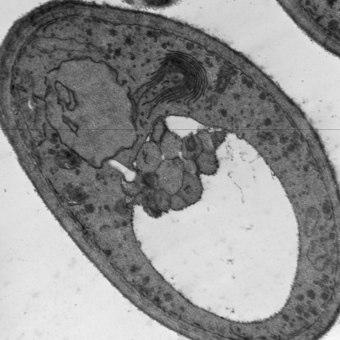

102.05 37.5487349986654
84.25 16.70591212714828
85.37 13.920240658839198
90.56 19.258411149417288
105.89666666666666 12.41260067655266
[219. 216. 215. 222. 214. 214. 203. 196. 177. 164. 137. 138. 139. 133.
 120. 117. 110. 108.  98.  88.  86.  93.  91.  90.  94.  89.  91.  96.
 100.  99.  84.  87.  84.  81.  75.  76.  76.  76.  74.  68.  66.  79.
  80.  85.  78.  67.  61.  66.  72.  81.  74.  67.  74.  80.  83.  88.
  90.  89.  80.  92.  89.  95.  87.  73.  80.  91. 105. 116. 117. 116.
 109. 109. 104. 102.  94.  91.  91.  89.  91.  95.  91.  87.  88.  91.
  88.  92.  87.  85.  92.  90.  94.  88.  82.  77.  84.  83.  86.  91.
  97.  98.]


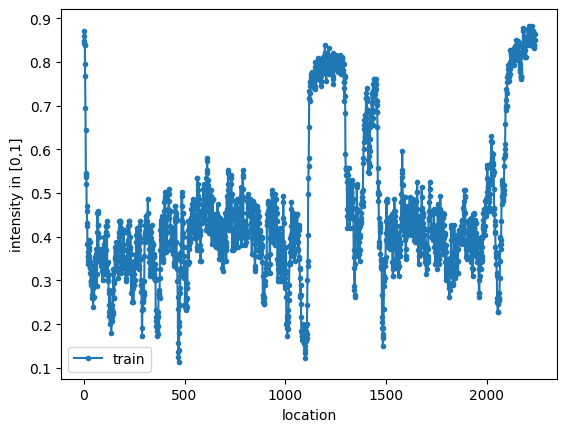

In [12]:
from PIL import Image

img = Image.open('B4-058.tif')
tmp_img_size1 = img.size
tmp_img_size2 = (tmp_img_size1[1], tmp_img_size1[0])

tmp = np.zeros((1,) + tmp_img_size2)  # batch size of 1, like below

tmp[0] = img
cross_sec_loc = int(img.size[0] * 0.38)
fig, ax = plt.subplots()
ax.set_xlabel('location')
ax.set_ylabel('intensity in [0,1]')
ax.plot(tmp[0, cross_sec_loc, :] / 255.0, '.-', label='train')
ax.legend()
# Also show the cell we're looking at, highlighting (in black) the cross section:
tmp0 = tmp.copy()
tmp0[0, cross_sec_loc, :] = 0
img_w_line = Image.fromarray(tmp0[0, :, :].astype('uint8'))
display(img_w_line.resize((340, 340)))
print(np.mean(tmp[0, cross_sec_loc, 0:100]), np.std(tmp[0, cross_sec_loc, 0:100]))
print(np.mean(tmp[0, cross_sec_loc, 100:200]), np.std(tmp[0, cross_sec_loc, 100:200]))
print(np.mean(tmp[0, cross_sec_loc, 200:300]), np.std(tmp[0, cross_sec_loc, 200:300]))

# Now some darker sections:
print(np.mean(tmp[0, cross_sec_loc, 950:1050]), np.std(tmp[0, cross_sec_loc, 950:1050]))
print(np.mean(tmp[0, cross_sec_loc, 1500:1800]), np.std(tmp[0, cross_sec_loc, 1500:1800]))
print(tmp[0, cross_sec_loc, 0:100])

In [14]:
from skimage.feature import hog
import cv2

ori = cv2.imread('B4-058.tif', 0)
img = cv2.imread('B4-058.tif', 0)
_, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                   cells_per_block=(1, 1), visualize=True)
cv2.imwrite('Original.png', ori)
cv2.imwrite('HoG.png', hog_image)

True